In [43]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from pandas.api.types import CategoricalDtype

import statsmodels
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import pprint
import math

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [44]:
# EVALUATION METRICS:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = np.mean(errors / test_labels)*100
    accuracy = 100 - mape
    rmse = np.sqrt(np.mean(errors**2))
    print('Model Performance')
    print('MAPE: {:0.4f}'.format(mape))
    print('RMSE: %.2f' % rmse)


# FINDING UNIMPORTANT FEATURES:
def feat_importances(df, target):
    # Labels are the dependent variable, transform to array
    labels = np.array(df[target])

    # Feature list of names, and transform to array
    features = df.drop(target, axis = 1)
    feature_list = list(features.columns)
    features = np.array(features)

    # training and testing sets
    train_features, test_features, train_labels, test_labels = \
    train_test_split(features, labels, test_size = 0.3, random_state = 42)

    # Instantiate model with 10 decision trees
    rf = RandomForestRegressor(n_estimators = 10, random_state = 42)

    # Train the model on training data
    rf.fit(train_features, train_labels)

    # Get feature importances
    importances = list(rf.feature_importances_)
    impdf = pd.DataFrame({'Feature':feature_list, 'Importance': np.round(importances, 4)})
    impdf = impdf.sort_values(['Importance'], ascending=True)
    return impdf



# RANDOM FOREST
def rf_general(df, target, droplist):
    # Labels are the dependent variable, transform to array
    labels = np.array(df[target])

    # Feature list of names, and transform to array
    features = df.drop(target, axis = 1)
    features =features.drop(droplist, axis=1)
    feature_list = list(features.columns)
    features = np.array(features)

    # training and testing sets
    train_features, test_features, train_labels, test_labels = \
    train_test_split(features, labels, test_size = 0.3, random_state = 42)

    # Instantiate model with 10 decision trees
    rf = RandomForestRegressor(n_estimators = 20, random_state = 42)

    # Train the model on training data
    rf.fit(train_features, train_labels)

    #evaluate
    evaluate(rf, test_features, test_labels)

    
# TUNED RANDOM FOREST
def rf_tuned(df, target, droplist):
    # Labels are the dependent variable, transform to array
    labels = np.array(df[target])

    # Feature list of names, and transform to array
    features = df.drop(target, axis = 1)
    features =features.drop(droplist, axis=1)
    feature_list = list(features.columns)
    features = np.array(features)

    # training and testing sets
    train_features, test_features, train_labels, test_labels = \
    train_test_split(features, labels, test_size = 0.3, random_state = 42)

    #parameters
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 110, num = 6)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [80, 90, 100]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 10, 15]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 3]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

    rf = RandomForestRegressor()
    # search across different combinations of parameters, and use all available scores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

    # Fit the random search model
    rf_random.fit(train_features, train_labels)

    # viewing performance of best model:
    print(rf_random.best_estimator_)
    evaluate(rf_random, test_features, test_labels)



# ADAPTIVE BOOSTING
def adaboost(df, target, droplist):
    labels = np.array(df[target])

    # Feature list of names, and transform to array
    features = df.drop(target, axis = 1)
    features = features.drop(droplist, axis=1)
    feature_list = list(features.columns)
    features = np.array(features)

    # training and testing sets
    train_features, test_features, train_labels, test_labels = \
    train_test_split(features, labels, test_size = 0.3, random_state = 42)

        #parameters
    #The maximum number of estimators at which boosting is terminated.
    n_estimators = [40, 60, 90]
    learning_rate = [.03, .05, .07]
    loss = ['linear', 'square', 'exponential']

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
                'loss' : loss}
    
    booster = AdaBoostRegressor()
    # search across different combinations of parameters, and use all available scores
    booster_random = RandomizedSearchCV(estimator = booster, param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

    # Fit the random search model
    booster_random.fit(train_features, train_labels)


    # viewing performance of best model:
    print(booster_random.best_estimator_)
    evaluate(booster_random, test_features, test_labels)


# GRADIENT BOOSTING
def gradientboost(df, target, droplist):
    labels = np.array(df[target])

    # Feature list of names, and transform to array
    features = df.drop(target, axis = 1)
    features = features.drop(droplist, axis=1)
    feature_list = list(features.columns)
    features = np.array(features)

    # training and testing sets
    train_features, test_features, train_labels, test_labels = \
    train_test_split(features, labels, test_size = 0.3, random_state = 42)

        #parameters
    #The maximum number of estimators at which boosting is terminated.
    n_estimators = [80, 100, 150]
    learning_rate = [.01, .05, 1, 2]
    loss = ['ls', 'lad', 'huber', 'quantile']
    subsample = [.1, .5, 1] 
    min_samples_split = [10, 20, 30]
    min_samples_leaf = [1, 2, 4]
    max_features = ['auto', 'sqrt', 'log2']

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
                'loss' : loss}
    
    gbr = GradientBoostingRegressor()
    # search across different combinations of parameters, and use all available scores
    gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = random_grid, 
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

    # Fit the random search model
    gbr_random.fit(train_features, train_labels)

    # viewing performance of best model:
    print(gbr_random.best_estimator_)
    evaluate(gbr_random, test_features, test_labels)

In [45]:
finaldf = pd.read_csv('/Users/Julia/Documents/bootcamp/DC_capstone/finaldf.csv', low_memory=False)
finaldf = finaldf[(finaldf['PRICE'] > 30000)] #removing properties sold under value
finaldf.reset_index(drop=True, inplace=True)
finaldf.head()

,PRICE,SALE_DATE,SALE_NUM,QUALIFIED,QUADRANT,WARD,SQUARE,NBHD,SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,ZIPCODE,LATITUDE,LONGITUDE,STYLE,STRUCT,USECODE,UNITS,STORIES,GRADE,CNDTN,LANDAREA,GBA,GBA_LIVING,YR_ORIGIN,YR_EXT,YR_RMDL,ROOMS,BEDRMS,BATHRMS,KITCHENS,HEAT,AC,FIREPLACES,ROOF,INTWALL,EXTWALL
0,1095000.0,2003-11-25 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914680,-77.040832,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Good,1680.0,2522.0,700.0,1910.0,1972.0,1988.0,8.0,4.0,4.0,2.0,Warm Cool,Y,5.0,Metal- Sms,Hardwood,Common Brick
1,2100000.0,2016-06-21 00:00:00,3.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914684,-77.040678,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Very Good,1680.0,2522.0,700.0,1910.0,1984.0,2009.0,9.0,5.0,3.5,2.0,Hot Water Rad,Y,4.0,Built Up,Hardwood,Common Brick
2,1602000.0,2006-07-12 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914683,-77.040629,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Good,1680.0,2484.0,700.0,1900.0,1984.0,2003.0,8.0,5.0,3.5,2.0,Hot Water Rad,Y,3.0,Built Up,Hardwood,Common Brick
3,1950000.0,2010-02-26 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914331,-77.039715,4 Story,Row Inside,11.0,1.0,4.0,Very Good,Good,2196.0,5344.0,700.0,1913.0,1972.0,2007.0,10.0,5.0,4.0,1.0,Hot Water Rad,Y,4.0,Built Up,Hardwood,Common Brick
4,1050000.0,2011-09-29 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2005,20009.0,38.915408,-77.040129,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Average,1627.0,2401.0,700.0,1906.0,1972.0,2011.0,8.0,4.0,3.5,2.0,Hot Water Rad,Y,1.0,Metal- Sms,Hardwood,Common Brick


In [46]:
# MODIFICATIONS

#new dataframe with timestamp instead of datetime for SALE_DATE
finaldf.SALE_DATE = pd.to_datetime(finaldf.SALE_DATE)

times = []
for i in finaldf['SALE_DATE']:
    times.append(datetime.timestamp(i))
finaldf['SALE_DATE'] = times
    
#dropping LATITUDE and LONGITUDE because these values zig-zag between properties.
#dropping CENSUS_TRACT because it's included in CENSUS_BLOCK.
dropdf = finaldf.drop(['LATITUDE', 'LONGITUDE', 'CENSUS_TRACT'], axis=1)

#remove spaces
strips=dropdf['CENSUS_BLOCK'].apply(str).str.replace(" ", "")
dropdf['CENSUS_BLOCK'] = strips

#change numerical to categorical
for col in ['SALE_NUM', 'SQUARE', 'CENSUS_BLOCK', 'USECODE', 'ZIPCODE']:
    dropdf[col] = dropdf[col].astype('category')

#remove high dimensionality (>60) geographical vars to improve run time
ndf = dropdf.drop(['CENSUS_BLOCK', 'SQUARE'], axis=1)


## DUMMIES:

In [47]:
# create dummy variables as needed
ndfdum = pd.get_dummies(ndf, drop_first=True)
ndfdum.head()

logdfdum = ndfdum.copy()
logprices = [math.log10(i) for i in logdfdum['PRICE']]
logdfdum['PRICE'] = logprices


In [48]:
rf_general(ndfdum, 'PRICE', [])

Model Performance
MAPE: 19.3547
RMSE: 144251.99


In [49]:
rf_general(logdfdum, 'PRICE', salenums)

Model Performance
MAPE: 1.2550
RMSE: 0.11


In [50]:
feat_importances(ndfdum, 'PRICE')

,Feature,Importance
200,SUBNBHD_049 C 16th Street Heights,0.0000
101,SUBNBHD_005 A Brentwood,0.0000
100,SUBNBHD_004 C Berkley,0.0000
98,SUBNBHD_004 A Berkley,0.0000
193,SUBNBHD_042 C Petworth,0.0000
194,SUBNBHD_043 A Randle Heights,0.0000
95,SUBNBHD_001 C American University,0.0000
94,SUBNBHD_001 B American University,0.0000
150,SUBNBHD_025 I Georgetown,0.0000
92,NBHD_Woodley,0.0000


### LEAST IMPORTANT FEATURES:
* 'EXTWALL'
* 'INTWALL'
* 'SALE_NUM'
* 'STYLE'
* 'ROOF'
* 'HEAT'
* 'CNDTN'

# TUNING

In [51]:
rf_tuned(logdfdum, 'PRICE', [])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.3min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=110, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Model Performance
MAPE: 1.2243
RMSE: 0.11


### ADAPTIVE BOOSTING

In [52]:
adaboost(logdfdum, 'PRICE', [])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 12.2min finished


AdaBoostRegressor(base_estimator=None, learning_rate=0.05, loss='linear',
         n_estimators=90, random_state=None)
Model Performance
MAPE: 3.0201
RMSE: 0.22


### GRADIENT BOOSTING

In [53]:
gradientboost(logdfdum, 'PRICE', [])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 24.4min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Model Performance
MAPE: 1.5099
RMSE: 0.13


## SUMMARY OF THE BEST MODEL

In [54]:
# Graphing error rates of best model:

labels = np.array(logdfdum['PRICE'])

# Feature list of names, and transform to array
features = logdfdum.drop('PRICE', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# training and testing sets
train_features, test_features, train_labels, test_labels = \
train_test_split(features, labels, test_size = 0.3, random_state = 42)

# Instantiate model
rf = RandomForestRegressor(bootstrap=True, 
    criterion='mse', 
    max_depth=80,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0, 
    min_impurity_split=None,
    min_samples_leaf=2, 
    min_samples_split=2,
    min_weight_fraction_leaf=0.0, 
    n_estimators=110, 
    n_jobs=None,
    oob_score=False, 
    random_state=42, 
    verbose=0, 
    warm_start=False)

# Train the model on training data
rf.fit(train_features, train_labels)

predictions = rf.predict(test_features)




In [94]:
dollarpred = np.array([math.exp(np.log(10)*i) for i in predictions])
dollary = np.array([math.exp(np.log(10)*i) for i in test_labels])
dollarerror = dollarpred - dollary
dollarerrorp = (dollarpred - dollary)/dollary*100
absdep = np.abs(dollarerrorp)
mape = np.mean(np.abs(dollarpred - dollary)/dollary)*100

In [120]:
np.round(mape, 2) #average percentage of price could be miscalculated 


17.27

In [104]:
#quantile of percentage errors
np.quantile(dollarerrorp, [.05, .1, .25, .5, .75, .9, .95])


array([-27.62306269, -19.96453599,  -9.91796207,  -1.16875374,
         8.47992618,  24.76948099,  44.6397084 ])

In [110]:
#quantiles of absolute percentage errors
np.quantile(absdep, [.05, .1, .25, .5, .75, .9, .95])

array([ 0.75022673,  1.51517186,  4.06841898,  9.31894651, 18.63040922,
       33.39640735, 49.76726427])

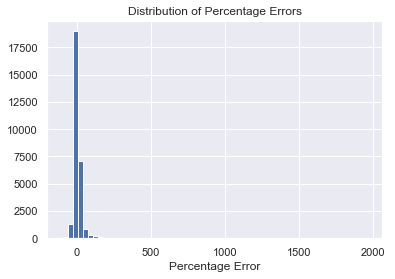

In [119]:
sns.set()
plt.hist(dollarerrorp, bins=60)
plt.title('Distribution of Percentage Errors')
plt.xlabel('Percentage Error')
plt.show()